<a href="https://colab.research.google.com/github/Shnku/pythoning_stuff/blob/proj/NN/build_cnn/expr1_resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data loading Part

## Mount google-drive & Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#shared path to drive
SHARED_PATH="/content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours"

#direct path to drive
DIRECT_PATH="/content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Determine the data path based on the existence of shared or direct paths
root_path = SHARED_PATH if os.path.exists(SHARED_PATH) else DIRECT_PATH if os.path.exists(DIRECT_PATH) else None

DATA_PATH = ''
# Print the chosen path or an error message
if root_path:
    print(f"Using path: {root_path}")
    DATA_PATH = root_path + "/Proj1_CGC_Building_with_sides_classify"
    for filename in os.listdir(DATA_PATH):
        print(filename)
else:
    print("Neither shared nor direct path exists. Please check the paths.")


Using path: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours
expr1_resnet18.ipynb
img_data
train_df.csv
img_data.csv
test_df.csv
make_csv_data_from_img_folder.ipynb
ResNet18_with_12_accy.pth
ResNet18_with_9_accy.pth


## Specify training and testing data path

In [ ]:
path_train_data= DATA_PATH + "/train_df.csv"
path_test_data= DATA_PATH + "/test_df.csv"

## Importing pytorch and setup CPU or GPU

In [ ]:
import torch
import random
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define device (CPU or GPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


#### Setup random state

In [ ]:
# Setup random state

# SEED = 2025
# torch.manual_seed(SEED)
# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(SEED)
#     torch.cuda.manual_seed_all(SEED)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
# os.environ['PYTHONHASHSEED'] = str(SEED)

## Define data transformations

In [ ]:
import torchvision.transforms as transforms

mean=[0.485, 0.456, 0.406]
standev=[0.229, 0.224, 0.225]
px=224

train_transform = transforms.Compose([
    transforms.Resize((px, px)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(mean), std=(standev))
])

test_transform =  transforms.Compose([
    transforms.Resize((px, px)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(mean), std=(standev))
])

print(train_transform)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


## Load dataset with Torch

In [ ]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image

df = pd.read_csv(path_train_data)
vdf = pd.read_csv(path_test_data)

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        # self.dataframe = pd.DataFrame(pd.read_csv(csv_file))
        self.dataframe = dataframe
        self.transform = transform
        # Create a mapping from class name to index
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.dataframe['class'].unique())}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = DATA_PATH + self.dataframe.iloc[idx]['path']
        label_name = self.dataframe.iloc[idx]['class']

        # read_image returns a tensor with shape [C, H, W]
        image = Image.open(img_path).convert('RGB') #RGB channel must
        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)
        # Convert label name to index
        label = self.class_to_idx[label_name]

        return image, label


train_dataset = CustomImageDataset(dataframe=df, transform=train_transform)
test_dataset = CustomImageDataset(dataframe=vdf, transform=test_transform)

### Visualization of transformation

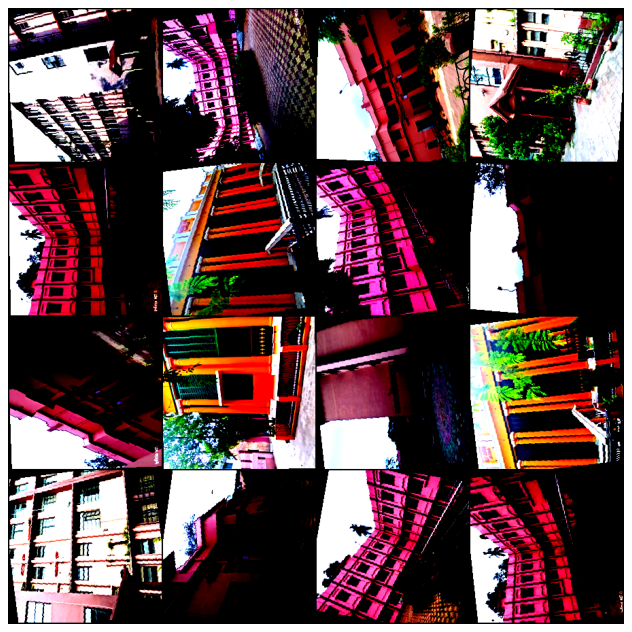

labels: tensor([9, 3, 8, 9, 4, 6, 6, 0, 8, 2, 5, 2, 9, 8, 6, 3])


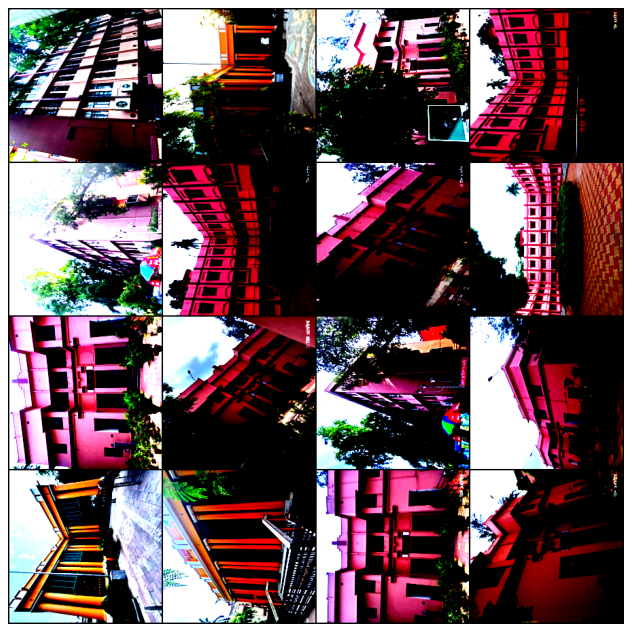

labels: tensor([ 6, 10,  3,  7,  8,  2,  3,  8,  1,  3, 10,  3,  4,  5,  0,  1])


In [ ]:
def disp_img_grid(dataset, mean, std):
    loader = DataLoader(dataset, batch_size=16, shuffle=True)
    batch = next(iter(loader))
    img, lbl = batch

    grid = torchvision.utils.make_grid(img, nrow=4) # Changed nrow to 4 for better visualization of multiple images
    plt.figure(figsize=(10, 10), dpi=80)
    plt.imshow(np.transpose(grid.permute(1, 2, 0).numpy(), (1, 0, 2)))
    plt.axis('off')  # Hide axes
    plt.show()  # Show the plot
    print(f'labels: {lbl}')

# Example usage with your custom datasets:
# Pass the dataset objects and the mean and std used for normalization
disp_img_grid(train_dataset, mean=mean, std=standev)
disp_img_grid(test_dataset, mean=mean, std=standev)

## Data loader

In [ ]:
# 4. Create DataLoader instances
BATCH_SIZE = 2

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(train_loader)
print(test_loader)

# Example of iterating through the DataLoader
print(train_dataset.class_to_idx)
print(len(train_dataset.class_to_idx))
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    break # Just show one batch


{'chemistry_right': 0, 'heritage_front': 1, 'gurudeb_left': 2, 'gurudeb_right': 3, 'gurudeb_front': 4, 'admin_right': 5, 'heritage_left': 6, 'admin_left': 7, 'chemistry_front': 8, 'admin_front': 9, 'chemistry_left': 10}
11
Batch of images shape: torch.Size([2, 3, 224, 224])
Batch of labels shape: torch.Size([2])


# CNN Defining and Training part

## Use Readymade CNN Model(ResNet) and modify it

In [ ]:
# Load torch's ResNet18 model
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# CNN_MODEL = models.resnet18(weights ='ResNet18_Weights.DEFAULT')  # pretrained = True/false
CNN_MODEL = models.resnet18(weights = None) # pretrained = False)
# CNN_MODEL = models.efficientnet_b4(weights = '') # pretrained = False)

### Model's Weights and biases Initialization

In [ ]:
import torch.nn as nn
import torch.nn.init as init

# with torch.no_grad():
for module in CNN_MODEL.modules():
    if isinstance(module, nn.Linear):
        init.kaiming_normal_(
            module.weight, a=0, mode='fan_out', nonlinearity='relu',
        )
        if module.bias is not None:
            fan_in, fan_out = init._calculate_fan_in_and_fan_out(module.weight)
            bound = 1 / (fan_out)**0.5
            init.normal_(module.bias, -bound, bound)

### We have to modify the last layer

In [ ]:
# modifying the last layer
# ResNet models have a 'fc' layer as the last linear layer
last_layer_in = CNN_MODEL.fc.in_features
no_of_classes = len(train_dataset.class_to_idx)
print(f"last layer output for model = {last_layer_in} -> convert to {no_of_classes} output")
CNN_MODEL.fc = nn.Linear(last_layer_in, no_of_classes)

last layer output for model = 512 -> convert to 11 output


### send the model to GPU/CPU

In [ ]:
# Move model to device
CNN_MODEL = CNN_MODEL.to(DEVICE)
print(CNN_MODEL)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### define loss function

In [ ]:
loss_fn = nn.CrossEntropyLoss() # criterion = torch.nn.CrossEntropyLoss()
print(loss_fn)

CrossEntropyLoss()


### Define optimaizer

In [ ]:
LEARNING_RATE = 0.002
optimizer = optim.Adam(CNN_MODEL.parameters(), lr=LEARNING_RATE) # lr = learning rate
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.002
    maximize: False
    weight_decay: 0
)


## Defining functions for train and validation

### function for training

In [ ]:
# from tqdm import tqdm
# In your train_NN function, after defining the optimizer:
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # Example scheduler

def train_NN(model, train_loader, test_loader, loss_function, optim, n_epochs=10):
    loss_graph_list, accy_list, valid_loss_list = [], [], [] # Changed variable name to avoid conflict
    for epoch in (range(n_epochs)):
        model.train()  # Set the model to training mode
        training_loss = [] # list to store the training loss for each batch

        for i_image, i_label in train_loader:
            i_image = i_image.to(DEVICE)
            i_label = i_label.to(DEVICE)

            optimizer.zero_grad() # Zero out the gradients to prevent accumulation
            output = model(i_image) # Get the model's output for the current batch of imgs
            loss = loss_function(output, i_label) # Calculate the loss using the defined loss function
            loss.backward()  # Perform backpropagation to compute gradients
            optimizer.step()  # Update the model's weights using the optimizer

            training_loss.append(loss.item())

        print("Training loss at", epoch, "iteration is", np.mean(training_loss))
        accy, current_valid_loss = eval_model_on_test(model, test_loader, loss_function) # Capture validation loss
        loss_graph_list.append(np.mean(training_loss))
        valid_loss_list.append(current_valid_loss) # Append the captured validation loss
        accy_list.append(accy)
    print("Training done.....................")
    return loss_graph_list, accy_list, valid_loss_list # Return the list of validation losses

### Function for validation test

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def eval_model_on_test(model, test_loader, loss_function=loss_fn, display_labels=test_dataset.class_to_idx, disp_confusion_matrix=False):
    model.eval()  # Set the model to evaluation mode
    pred_correctly = 0
    total = 0
    actual_labels = []
    predicted_labels = []
    validation_loss = [] # list to store the validation loss for each batch

    with torch.no_grad():
        for i_image, i_label in test_loader:
            i_image = i_image.to(DEVICE)
            i_label = i_label.to(DEVICE)

            total += i_label.size(0) # number of samples in the current batch
            output = model(i_image)

            # Calculate validation loss
            loss = loss_function(output, i_label)
            validation_loss.append(loss.item())

            # get predicted class index (max probability) for each image in the batch
            _, predicted = torch.max(output.data, 1) # its indx along (dimension 1,which corresponds to the class scores).
            pred_correctly += (predicted == i_label).sum().item() # total count of correctly predicted samples.

            # Collect actual_labels & pridected_labels for confusion matrix
            actual_labels.extend(i_label.cpu().numpy()) # tensor -> NP array and extending the list.
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = 100.0 * pred_correctly / total
    average_validation_loss = np.mean(validation_loss) # Calculate the average validation loss
    print(f' --Testing........got-({pred_correctly}/{total})-correctly -->> accuracy=({accuracy:.2f}%)', end='')
    print(f' --Validation loss: {average_validation_loss:.4f}') # Print the validation loss


    # Generate and display confusion matrix
    if disp_confusion_matrix:
        ConfusionMatrixDisplay(
            confusion_matrix=confusion_matrix(actual_labels, predicted_labels),
            display_labels=display_labels
        ).plot()
        plt.xticks(rotation=90)
        plt.show()
    return accuracy, average_validation_loss # Return both accuracy and validation loss


## Doing train

In [ ]:
# Set no of epoches or train iteration
ITERATION = 20
# call train funtion
iter_loss, iter_accy, valid_loss = train_NN(
    CNN_MODEL, train_loader, test_loader, loss_fn, optimizer, n_epochs=ITERATION,
)

Training loss at 0 iteration is 2.749653478329246
 --Testing........got-(4/74)-correctly -->> accuracy=(5.41%)
 --Validation loss: 2.9265
Training loss at 1 iteration is 2.536791910996308
 --Testing........got-(4/74)-correctly -->> accuracy=(5.41%)
 --Validation loss: 4.4194
Training loss at 2 iteration is 2.4464264785921253
 --Testing........got-(6/74)-correctly -->> accuracy=(8.11%)
 --Validation loss: 3.0357
Training loss at 3 iteration is 2.284064751219105
 --Testing........got-(9/74)-correctly -->> accuracy=(12.16%)
 --Validation loss: 3.4731
Training loss at 4 iteration is 2.2585857107832625
 --Testing........got-(10/74)-correctly -->> accuracy=(13.51%)
 --Validation loss: 4.2880
Training loss at 5 iteration is 2.2533171756847485
 --Testing........got-(6/74)-correctly -->> accuracy=(8.11%)
 --Validation loss: 3.0379
Training loss at 6 iteration is 2.1497643525535994
 --Testing........got-(2/74)-correctly -->> accuracy=(2.70%)
 --Validation loss: 3.0878
Training loss at 7 iteratio

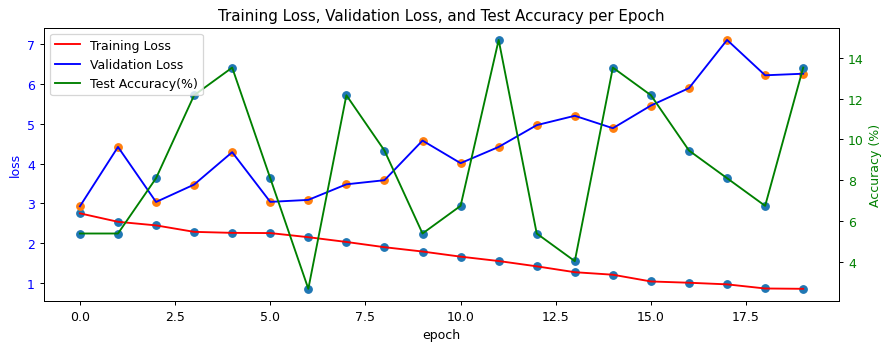

In [ ]:
import matplotlib.pyplot as plt

def ploting(ax, arr, color,lname, ylabel='loss', xlabel='epoch'):
    ax.plot(arr, color=color, label=lname)
    ax.scatter(range(len(arr)),arr)
    ax.set_ylabel(ylabel, color=color)
    ax.tick_params(axis='y', labelcolor=color)
    ax.set_xlabel(xlabel)


# Create a figure and the first axes
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=90)
# Create a second axes that shares the same x-axis as the first
ax2 = ax1.twinx()

# Plotting loss and valid loss on ax1 (left y-axis)
ploting(ax1, iter_loss, color='red', lname='Training Loss')
ploting(ax1, valid_loss, color='blue', lname='Validation Loss')
# Plotting accuracy on ax2 (right y-axis)
ploting(ax2, iter_accy, color='green', lname='Test Accuracy(%)',ylabel='Accuracy (%)')

# Add a legend: Combine handles and labels from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
# Create a single legend for all lines
plt.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

plt.title('Training Loss, Validation Loss, and Test Accuracy per Epoch')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

## Validate the model

 --Testing........got-(10/74)-correctly -->> accuracy=(13.51%)
 --Validation loss: 6.2613


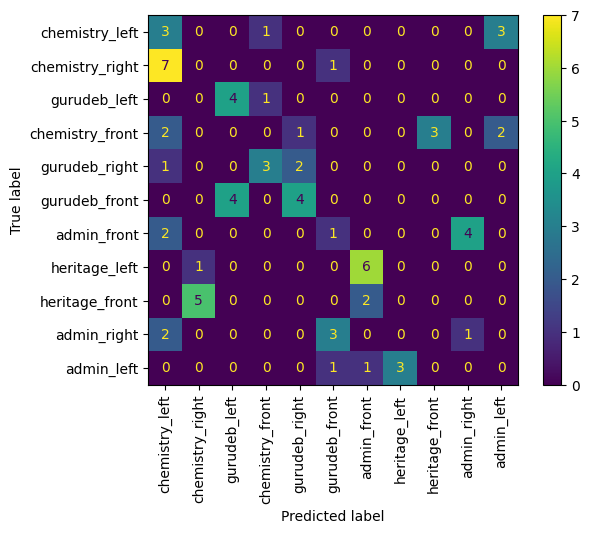

In [ ]:
# call evaluation function
accuracy,_ = eval_model_on_test(
    CNN_MODEL, test_loader, disp_confusion_matrix=True,
)

## Save trained model

In [ ]:
# print(CNN_MODEL.state_dict())
# torch.save(CNN_MODEL.state_dict(), DATA_PATH +'/resnet18_image_classifier.pth')

#save entire model
model_name = CNN_MODEL.__class__.__name__ + '18'
print(model_name)

torch.save(CNN_MODEL, DATA_PATH+'/'+model_name+'_with_'+ str(int(accuracy))+'_accy.pth')

os.listdir(DATA_PATH)

ResNet18


['expr1_resnet18.ipynb',
 'img_data',
 'train_df.csv',
 'img_data.csv',
 'test_df.csv',
 'make_csv_data_from_img_folder.ipynb',
 'ResNet18_with_12_accy.pth',
 'ResNet18_with_9_accy.pth',
 'ResNet18_with_13_accy.pth']

# Individual testing

## Predefined parameters

In [ ]:
# MODEL = DATA_PATH+"/resnet18_image_classifier_full.pth"
MODEL = CNN_MODEL
TRANSFORM = test_transform
# Update the CATEGORIES variable to be a list of keys
CATEGORIES = list(test_dataset.class_to_idx.keys())
print(CATEGORIES)


['chemistry_left', 'chemistry_right', 'gurudeb_left', 'chemistry_front', 'gurudeb_right', 'gurudeb_front', 'admin_front', 'heritage_left', 'heritage_front', 'admin_right', 'admin_left']


## Function for individual image classification

In [ ]:
from PIL import Image

def classify_this_image(img_path, model=MODEL,img_transform=TRANSFORM,classes=CATEGORIES):
    model.eval() # set model to evaluation/testing mode
    input_img = Image.open(DATA_PATH + img_path)

    plt.figure(figsize=(10, 10),dpi=30)
    plt.imshow(input_img) # display the loaded image
    plt.axis('off')
    plt.show()

    img_tensor = img_transform(input_img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        print(probabilities)
        _, predicted_class_index = torch.max(probabilities, 1)
        predicted_class = classes[predicted_class_index.item()]
        print(f"Predicted class: {predicted_class}")

## Input image and Classify

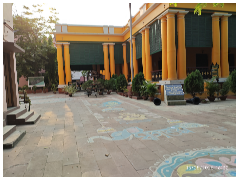

tensor([[5.8580e-03, 7.3842e-01, 5.6475e-07, 1.0978e-06, 1.7163e-04, 3.5654e-06,
         2.3671e-01, 4.0022e-04, 1.7957e-02, 4.6296e-04, 5.7495e-06]],
       device='cuda:0')
Predicted class: chemistry_right


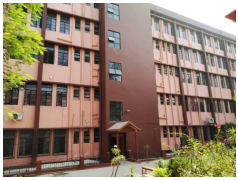

tensor([[7.8350e-01, 1.1453e-03, 2.8822e-04, 1.2586e-03, 1.9883e-03, 4.0884e-02,
         1.1829e-02, 1.2798e-02, 3.0871e-02, 9.3099e-02, 2.2339e-02]],
       device='cuda:0')
Predicted class: chemistry_left


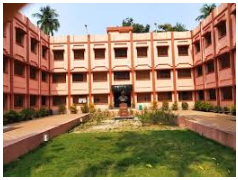

tensor([[3.3512e-02, 6.1911e-04, 1.1982e-02, 4.4480e-02, 8.7640e-01, 3.1259e-04,
         6.5334e-06, 3.2450e-07, 8.9509e-03, 6.1183e-05, 2.3679e-02]],
       device='cuda:0')
Predicted class: gurudeb_right


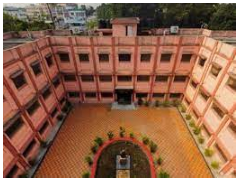

tensor([[0.1989, 0.0429, 0.0431, 0.0039, 0.3100, 0.0053, 0.2360, 0.0007, 0.1352,
         0.0111, 0.0127]], device='cuda:0')
Predicted class: gurudeb_right


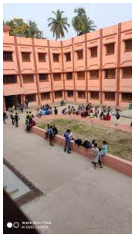

tensor([[1.8980e-01, 4.3487e-03, 1.4478e-02, 3.8757e-02, 5.6272e-01, 4.3189e-05,
         1.6363e-04, 3.2969e-05, 1.2954e-01, 4.0852e-03, 5.6033e-02]],
       device='cuda:0')
Predicted class: gurudeb_right


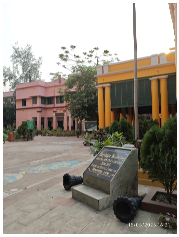

tensor([[3.8597e-02, 3.3341e-01, 1.1441e-03, 2.7974e-04, 4.7883e-01, 6.8621e-03,
         1.7292e-02, 1.7717e-02, 8.7604e-02, 1.3022e-02, 5.2343e-03]],
       device='cuda:0')
Predicted class: gurudeb_right


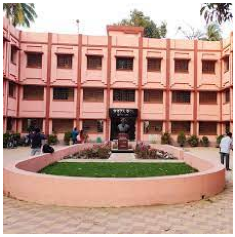

tensor([[4.4809e-02, 2.4609e-03, 7.0546e-02, 3.4080e-01, 1.0712e-01, 1.3021e-06,
         3.0653e-03, 6.3895e-06, 4.2574e-01, 3.9931e-04, 5.0509e-03]],
       device='cuda:0')
Predicted class: heritage_front


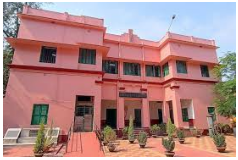

tensor([[4.7729e-01, 2.2719e-05, 2.7312e-03, 1.6689e-02, 4.6288e-04, 1.6559e-06,
         3.2243e-01, 1.2871e-04, 2.8971e-02, 2.5431e-04, 1.5101e-01]],
       device='cuda:0')
Predicted class: chemistry_left


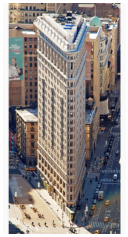

tensor([[4.7557e-02, 4.1948e-04, 1.4458e-06, 3.0621e-06, 3.5180e-04, 8.8840e-01,
         6.9723e-04, 6.2362e-03, 9.8198e-05, 5.6200e-02, 4.0242e-05]],
       device='cuda:0')
Predicted class: gurudeb_front


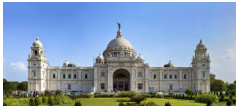

tensor([[7.9832e-02, 1.6425e-03, 5.4432e-06, 1.1864e-04, 7.8876e-04, 8.7616e-01,
         4.1911e-04, 1.8803e-03, 2.4078e-03, 3.6383e-02, 3.5801e-04]],
       device='cuda:0')
Predicted class: gurudeb_front


In [ ]:
# Call the classification function
classify_this_image("/../Testing_data_mix/Heritage_test/fview_0001.jpg")
classify_this_image("/../Testing_data_mix/Admin_test/campus-admin-building.jpg")
classify_this_image("/../Testing_data_mix/Gurudeb_test/images (2).jpeg")
classify_this_image("/../Testing_data_mix/Gurudeb_test/images (3).jpeg")
classify_this_image("/../Testing_data_mix/Gurudeb_test/images (4).jpeg")
classify_this_image("/../Testing_data_mix/Heritage_test/Copy of diagonal_0002.jpg")
classify_this_image("/../Testing_data_mix/Gurudeb_test/images (5).jpeg")
classify_this_image("/../Testing_data_mix/Chemistry_test/images (8).jpeg")
classify_this_image("/../Testing_data_mix/Unknown_test/flatiron.jpeg")
classify_this_image("/../Testing_data_mix/Unknown_test/victoria.jpeg")

In [ ]:
# GradCAM